In [1]:
# This file plots the elevation gradients of bus route road segments with a
# red/blue diverging color map to indicate uphill (red) and downhill (blue)
# slopes.

In [1]:
import geopandas as gpd
import json
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy as npm
import osmnx as ox
import pandas as pd
from shapely.ops import snap

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
CRS = 'EPSG:4326'
DATA_DIR = '../../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'

In [4]:
# Load GraphML for Manhattan (New York, NY).
ny_road_mg = ox.load_graphml(f'{EXPORTS_DIR}/graphml/manhattan/ny.graphml')

In [5]:
ny_bus_mg = ox.load_graphml(f'{EXPORTS_DIR}/graphml/manhattan/routes.graphml')

In [6]:
def plot(road_mg, route_mg, edge_colors):
    # Determine bounding box for plotting.
    bbox_west = min([road_mg.nodes[n]['x'] for n in road_mg.nodes])
    bbox_east = max([road_mg.nodes[n]['x'] for n in road_mg.nodes])
    bbox_north = max([road_mg.nodes[n]['y'] for n in road_mg.nodes])
    bbox_south = min([road_mg.nodes[n]['y'] for n in road_mg.nodes])
    bbox = (bbox_north, bbox_south, bbox_east, bbox_west)
    
    # Plot all collected routes to visualize network coverage.
    fig, ax = plt.subplots(figsize=(50, 50))
    ox.plot_graph(road_mg,
                  ax=ax,
                  bgcolor='#444',
                  node_size=0,
                  show=False,
                  close=False,
                  edge_color='#3a3a3a',
                  bbox=bbox)
    
    ox.plot_graph(route_mg,
                  ax=ax,
                  bgcolor='#444',
                  node_size=0,
                  show=False,
                  close=False,
                  edge_color=edge_colors,
                  edge_linewidth=3,
                  bbox=bbox)
    ax.set_facecolor('#444')
    plt.show()

In [7]:
def get_edge_colors_zero_centered(mg, attr, threshold=0.5, cmap='seismic'):
    """Modified OSMNX function to center the values such that zero is 50% of the
    colormap. Useful for comparing positive/negative values where a neutral
    color in a divergent colormap corresponding to 0 is desired."""
    start = 0
    stop = 1
    na_color = '#ffffff'
    
    values = pd.Series(nx.get_edge_attributes(mg, attr))
    
    values_min = values.dropna().min()
    values_max = values.dropna().max()
    
    # Reduce extent by threshold amount such that everything above it is maximum
    # (or below negative is minimum), i.e. truncate the colormap range.
    max_extent = max(abs(values_min), abs(values_max)) * threshold
    abs_min = -max_extent
    abs_max = max_extent
    
    full_range = (abs_max - abs_min) / (stop - start)
    full_min = abs_min - full_range * start
    full_max = full_min + full_range

    # linearly map a color to each attribute value
    normalizer = colors.Normalize(full_min, full_max)
    scalar_mapper = cm.ScalarMappable(normalizer, cm.get_cmap(cmap))
    color_series = values.map(scalar_mapper.to_rgba)
    color_series.loc[pd.isnull(values)] = na_color
    
    return color_series

In [8]:
# Create red/blue colormap with gray in middle.
def create_red_blue_colormap():
    mid_color = 16 / 256

    red = np.ones((256, 4))
    red[:, 0] = np.linspace(65 / 256, mid_color, 256)
    red[:, 1] = np.linspace(0 / 256, mid_color, 256)
    red[:, 2] = np.linspace(255 / 256, mid_color, 256)
    red_colormap = colors.ListedColormap(red)

    blue = np.ones((256, 4))
    blue[:, 0] = np.linspace(255 / 256, mid_color, 256)
    blue[:, 1] = np.linspace(0 / 256, mid_color, 256)
    blue[:, 2] = np.linspace(65 / 256, mid_color, 256)
    blue_colormap = colors.ListedColormap(blue)

    red_blue = np.vstack(
        (red_colormap(np.linspace(0, 1, 128)), blue_colormap(np.linspace(1, 0,
                                                                         128))))
    return colors.ListedColormap(red_blue)

red_blue_colormap = create_red_blue_colormap()

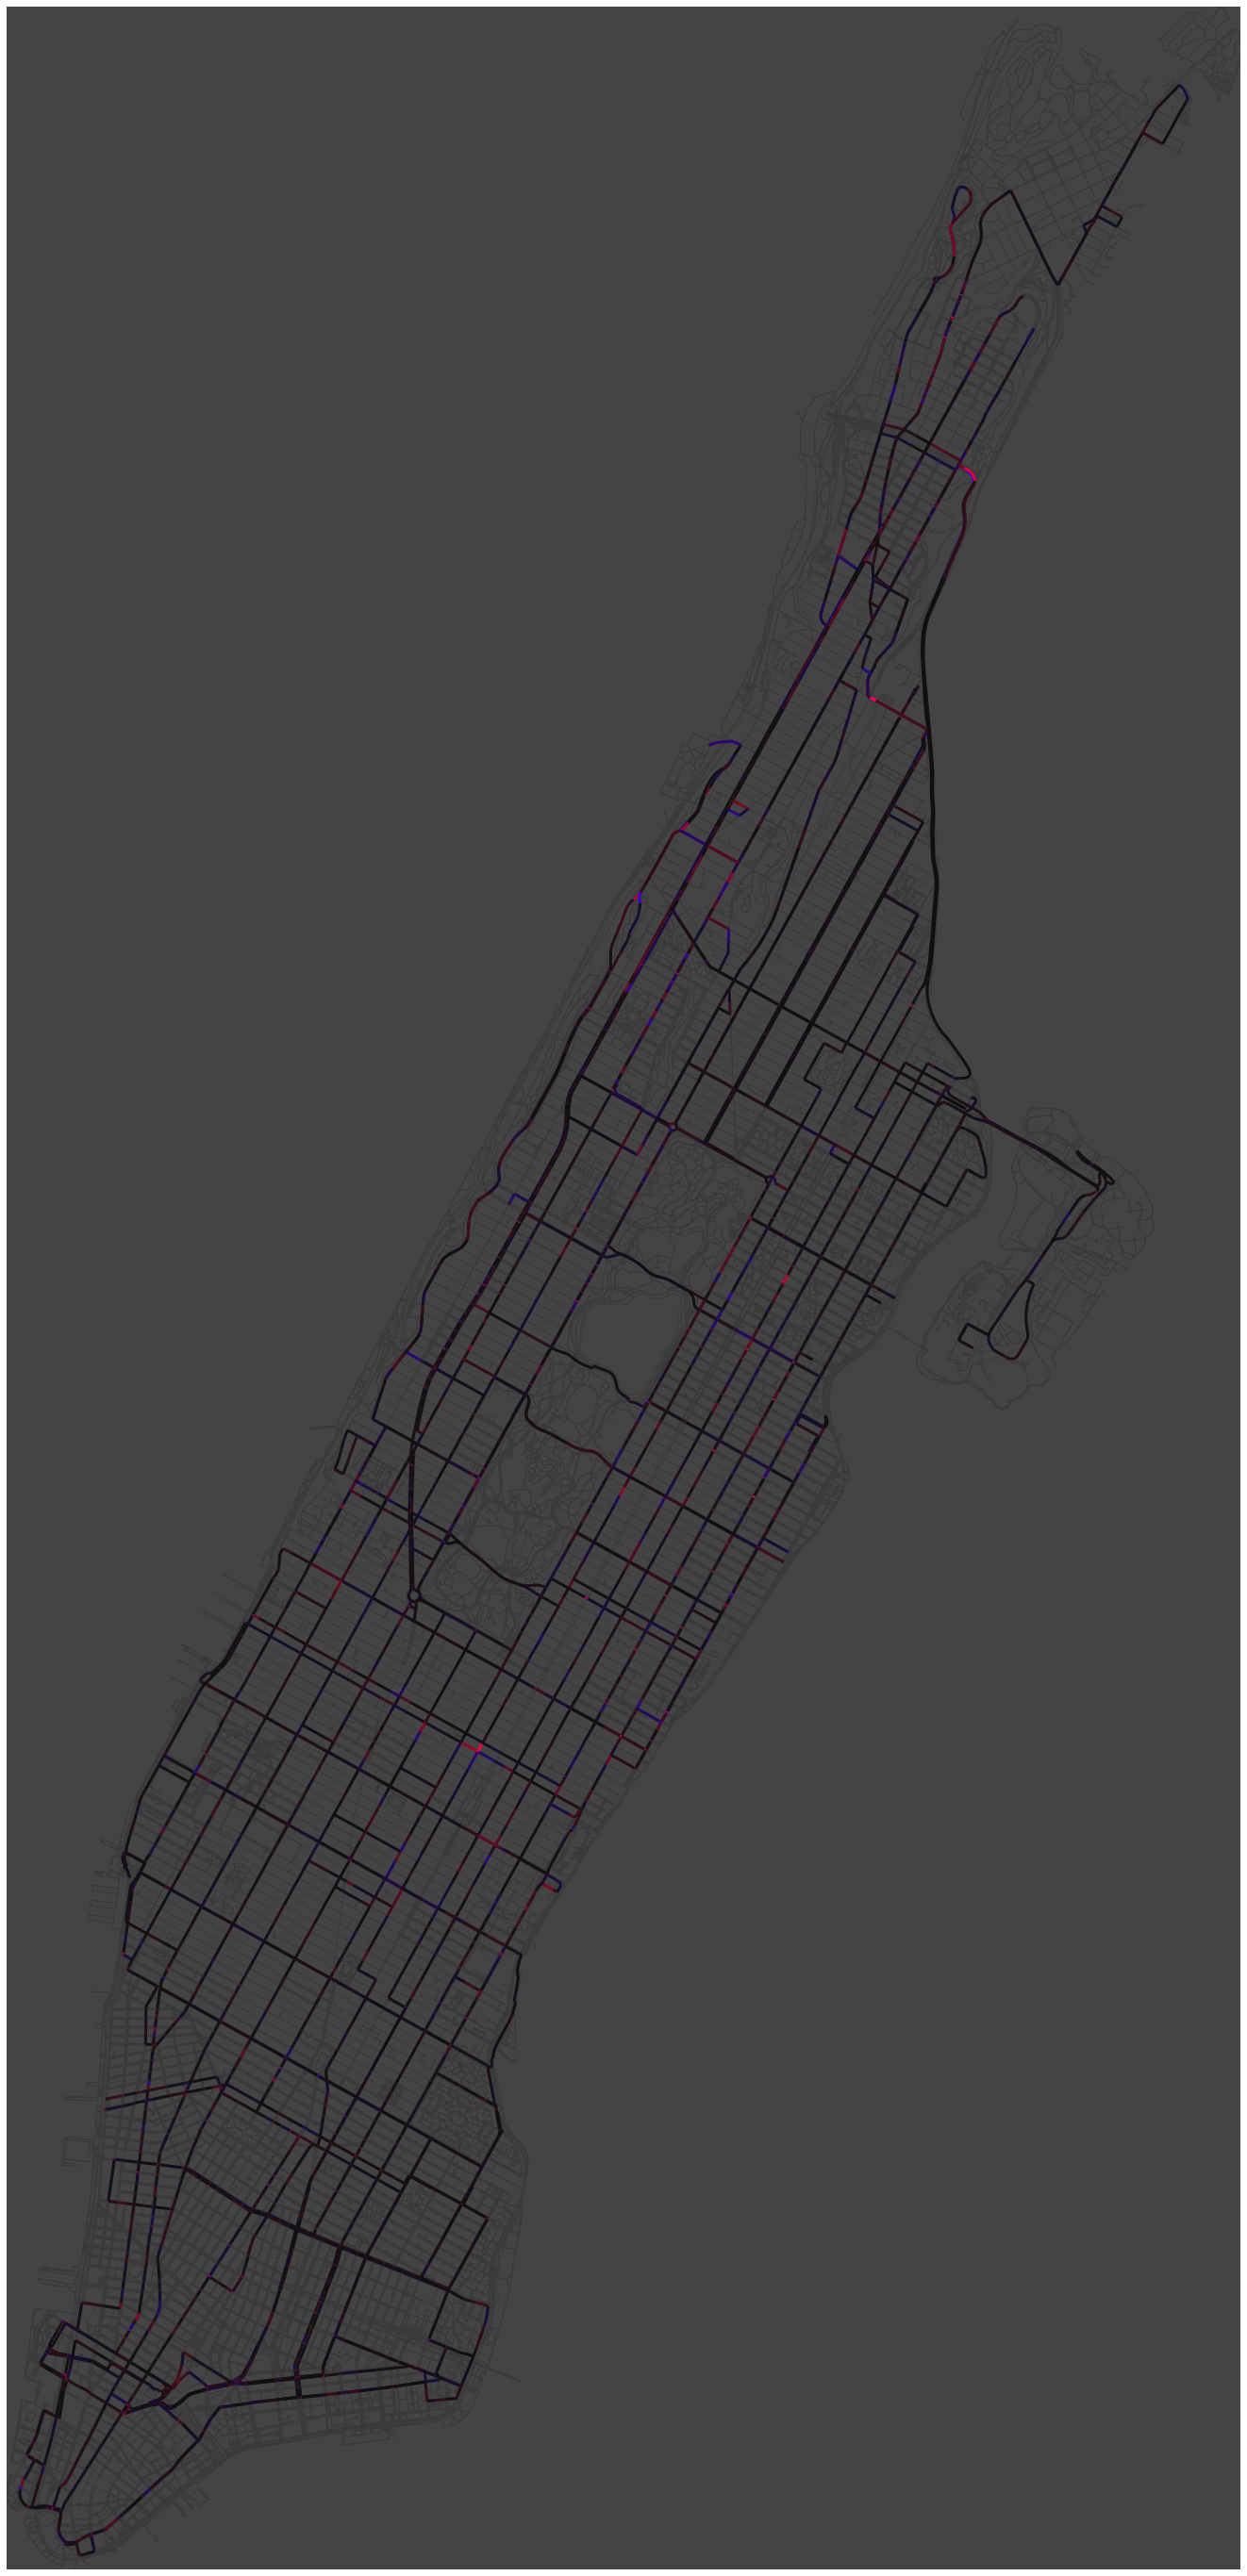

In [9]:
red_blue_colormap = create_red_blue_colormap()
edge_colors = get_edge_colors_zero_centered(ny_bus_mg,
                                            'grade',
                                            threshold=0.5,
                                            cmap=red_blue_colormap)
plot(ny_road_mg, ny_bus_mg, edge_colors)